In [215]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Import data

In [216]:
df = pd.read_csv("../../data/raw_data/2023_merged_gw.csv")
df.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Nathan Redmond,MID,Southampton,1.5,0,0,3,0,0.0,403,...,4,0.0,1,0,0,0,55,False,0,1
1,Junior Stanislas,MID,Bournemouth,1.1,0,0,3,0,0.0,58,...,2,0.0,1,0,0,0,50,True,0,1
2,Armando Broja,FWD,Chelsea,2.0,0,0,3,0,0.3,150,...,0,19.0,1,0,0,0,55,False,0,1
3,Fabian Schär,DEF,Newcastle,2.4,0,3,43,1,14.6,366,...,2,25.0,15,0,0,0,45,True,0,1
4,Jonny Evans,DEF,Leicester,1.9,0,0,15,0,1.3,249,...,2,0.0,1,0,0,0,45,True,0,1


# Calculate baseline for FPL points forecast 

Generate list of boundaries for m_wks_pre and n_wks_post

In [217]:
pre_post_boundary_list = [] 
m = 10
n = 5

for i in range(1, (40-(m+n))): 
    boundary_pair = [range(i, i+m), range(i+m, i+(m+n))]
    pre_post_boundary_list.append(boundary_pair)
pre_post_boundary_list

[[range(1, 11), range(11, 16)],
 [range(2, 12), range(12, 17)],
 [range(3, 13), range(13, 18)],
 [range(4, 14), range(14, 19)],
 [range(5, 15), range(15, 20)],
 [range(6, 16), range(16, 21)],
 [range(7, 17), range(17, 22)],
 [range(8, 18), range(18, 23)],
 [range(9, 19), range(19, 24)],
 [range(10, 20), range(20, 25)],
 [range(11, 21), range(21, 26)],
 [range(12, 22), range(22, 27)],
 [range(13, 23), range(23, 28)],
 [range(14, 24), range(24, 29)],
 [range(15, 25), range(25, 30)],
 [range(16, 26), range(26, 31)],
 [range(17, 27), range(27, 32)],
 [range(18, 28), range(28, 33)],
 [range(19, 29), range(29, 34)],
 [range(20, 30), range(30, 35)],
 [range(21, 31), range(31, 36)],
 [range(22, 32), range(32, 37)],
 [range(23, 33), range(33, 38)],
 [range(24, 34), range(34, 39)]]

Get rolling average player points for pre and post periods 

In [218]:
df_list = []

for boundaries in pre_post_boundary_list: 
    df_pre = df[df["GW"].isin(boundaries[0])]
    df_post = df[df["GW"].isin(boundaries[1])]

    df_agg_points_pre = df_pre.groupby(["name", "position"]).agg({"total_points": "mean"})
    df_agg_points_post = df_post.groupby(["name", "position"]).agg({"total_points": "mean"})

    df_agg_points = df_agg_points_pre.merge(df_agg_points_post, on=["name", "position"], how="left")
    df_agg_points.columns = ["avg_pts_pre", "avg_pts_post"]

    df_list.append(df_agg_points)

df_pre_post_pts = pd.concat(df_list)

In [219]:
df_pre_post_pts

,,avg_pts_pre,avg_pts_post
name,position,,
Aaron Cresswell,DEF,2.222222,3.2
Aaron Hickey,DEF,1.444444,0.0
Aaron Ramsdale,GK,3.111111,6.0
Aaron Wan-Bissaka,DEF,0.125000,0.0
Abdoulaye Doucouré,MID,0.555556,0.4
...,...,...,...
Youri Tielemans,MID,0.636364,2.8
Yves Bissouma,MID,0.000000,0.8
Zack Steffen,GK,0.000000,0.0


# Visualise results and establish baseline statistics 

Calculate rmse and r2_score

In [220]:
pred = np.array(df_pre_post_pts["avg_pts_pre"])
true = np.array(df_pre_post_pts["avg_pts_post"])

rmse = np.sqrt(mean_squared_error(true, pred))
r2 = r2_score(true, pred)

print("rmse:", rmse)
print("r2:", r2)

rmse: 1.256293266288406
r2: 0.3992381036273135


Visualisation

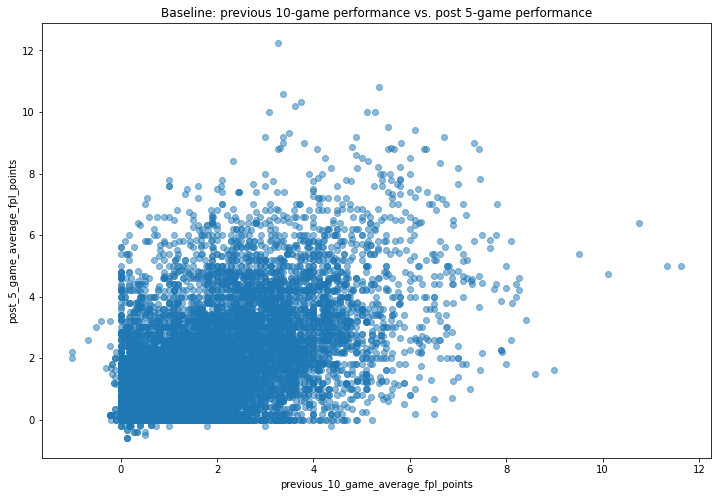

In [224]:
plt.figure(figsize=(12, 8), facecolor="white")
plt.scatter(pred, true, alpha=0.5)
plt.xlabel(f"previous_{m}_game_average_fpl_points")
plt.ylabel(f"post_{n}_game_average_fpl_points")
plt.title(f"Baseline: previous {m}-game performance vs. post {n}-game performance") 
plt.show()